## 背景
本周的挑战是使用来自[此处](https://www.kaggle.com/annavictoria/speed-dating-experiment)的数据来预测一个人是否能够match。

此处研究的是到底什么影响了第一眼的印象？

## 0. 加载库

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1) 处理数据
1.1 清理

1.2 转换

1.3 PCA降维

In [4]:
df =pd.read_csv('Speed Dating Data.csv',encoding="ISO-8859-1")
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


先将feature和label分开

In [17]:
df, df_labels = df.drop(['match'], axis=1), df['match']

### 1.1 清理数据
如果某一个label 为 null的数量超过了30%，则放弃该列

In [23]:
na_sum = list(df.isnull().sum()) # 每个label中null的总数
na_col = list(df.isnull().sum().index) # label名词

In [24]:
drop_col =[]
for i in range(len(na_sum)):
    if na_sum[i] > 2513:#8377*0.3
        drop_col.append(na_col[i])
print("We can drop ",len(drop_col)," Columns")

We can drop  83  Columns


In [25]:
df = df.drop(drop_col,axis=1)
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2
0,1,1.0,0,1,1,1,10,7,NaN,4,...,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
1,1,1.0,0,1,1,1,10,7,NaN,3,...,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0


将NaN值填充为均值

In [26]:
df = df.fillna(df.mean())

In [34]:
# 检查是否有null值了
df.isnull().sum().values

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         63,    0,    0,    0,    0,   79, 1064,    0,    0,    0,   89,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

从上面可以看出还是有null值，将其打印出来

In [32]:
na_sum = list(df.isnull().sum())
na_col = list(df.isnull().sum().index)
nan_col =[]
for i in range(len(na_sum)):
    if na_sum[i] > 0:
        nan_col.append(na_col[i])
nan_col

['field', 'from', 'zipcode', 'career']

我们来这下这几列值

In [35]:
df[['field', 'from', 'zipcode', 'career']].head()

,field,from,zipcode,career
0,Law,Chicago,"60,521",lawyer
1,Law,Chicago,"60,521",lawyer
2,Law,Chicago,"60,521",lawyer
3,Law,Chicago,"60,521",lawyer
4,Law,Chicago,"60,521",lawyer


这些值都不是数值的，而是一些具体的值，我们暂时写去除这些列

In [37]:
df = df.drop(['field', 'from', 'zipcode', 'career'],axis=1)

In [38]:
df.isnull().values.any()

False

### 1.2转换数据
为什么需要转换呢?看图：
<img src="image/Mean Variance - Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
X = StandardScaler().fit_transform(df)

### 1.3 PCA处理

我们通过PCA来进行降维，找出其中有区分度的维度，减少计算量

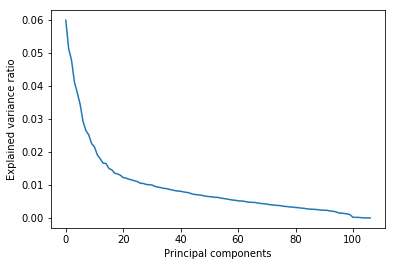

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#PCA In Sklearn
from sklearn.decomposition import PCA

pca_full = PCA(n_components = None)
pca_full.fit(X)

plt.plot(range(0,107), pca_full.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
#plt.xticks(np.arange(0,100,5))
plt.show()

从上图中，我们选择80个主成分

In [44]:
x_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components = 80)
x_pca = pca.fit_transform(x_scaled)
# print(x_pca, end = '\n\n')
# print(pca.explained_variance_ratio_)
x_pca.shape

(8378, 80)

## 2. 训练模型
我们会选择3个模型，然后进行比较

- 2.1 Manually made neural network
- 2.2 Tensorflow
- 2.3 SVM
- 2.3 Logistic regression

首先将数据分为test和train

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_pca, df_labels, test_size=0.2, random_state=0)

### 2.1 首先神经网络

In [46]:
class MyNeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes =  input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_0_1 = np.zeros((self.hidden_nodes,self.input_nodes))

        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.sigmoid_activation = lambda x : 1 / (1 + np.exp(-x))
        self.sigmoid_output_2_derivative = lambda x: x * (1 - x)
        #self.logistic_classifier = lambda x : 1 if x > 0.5 else 0
    
    def train(self, inputs_array, targets_array):
        # Convert inputs list to 2d array
        inputs  = inputs_array.T
        targets = np.array(targets_array, ndmin=2)
        m = inputs_array.shape[0] # number of records
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        layer_1_inputs = np.dot(self.weights_0_1, inputs) # signals into hidden layer
        layer_1 = layer_1_inputs # signals from hidden layer
        
        # TODO: Output layer
        layer_2_inputs = np.dot(self.weights_1_2,layer_1) # signals into final output layer
        layer_2 = self.sigmoid_activation(layer_2_inputs) # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error  
        layer_2_errors = targets - layer_2  # Output layer error is the difference between desired target and actual output.
        layer_2_delta = layer_2_errors * self.sigmoid_output_2_derivative(layer_2)
        
        # TODO: Backpropagated error
        layer_1_errors = np.dot(self.weights_1_2.T,layer_2_delta) # errors propagated to the hidden layer 2x128
        layer_1_delta = layer_1_errors * 1  # hidden layer gradients y = x -> 1
        
        # TODO: Update the weights
        self.weights_1_2 += self.lr*np.dot(layer_2_delta,layer_1.T)/m # update hidden-to-output weights with gradient descent step
        self.weights_0_1 += self.lr*np.dot(layer_1_delta,inputs.T)/m # update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_0_1, inputs) # signals into hidden layer
        hidden_outputs = hidden_inputs # signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_1_2,hidden_outputs) # signals into final output layer
        final_outputs = self.sigmoid_activation(final_inputs) # signals from final output layer 
        
        return final_outputs

In [47]:
### Set the hyperparameters here ###
epochs = 1000 #100
learning_rate = 0.01 #0.1
hidden_nodes = 40 
output_nodes = 1

N_i = X_train.shape[1]
network = MyNeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

network.train(X_train, y_train)

y_pred = network.run(X_test)

In [48]:
y_pred = np.where(y_pred >= 0.5, 1, 0) # if probability >= 0.5, it is 1, else 0

In [49]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred[0]))

0.649164677804


### 2.2 Tensorflow